In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

# data

Load OHLC data from cryptocurrency exchange Poloniex.

In [3]:
ohlc_df = vbt.data.load_cryptopair('USDT_BTC', vbt.data.ago_dt(days=360), vbt.data.now_dt(), period=86400)
ohlc_df.head()

done. 0.88s


,O,H,L,C,V
date,,,,,
2016-12-03,775.725531,776.775836,756.776947,764.259738,215171.174707
2016-12-04,767.515373,772.500000,761.972809,771.797999,147413.035809
2016-12-05,771.797999,772.963000,747.000000,753.340000,552583.819494
2016-12-06,753.499996,763.517010,748.873104,758.210223,659929.997652
2016-12-07,757.816490,770.500000,753.000000,766.089390,307676.745397


In [4]:
# No future data
rate_sr = ohlc_df.O

In [5]:
# Fees and slippage
fees = 0.025
slippage_factor = 0.25
slippage = (ohlc_df['H'] - ohlc_df['L']) * slippage_factor / rate_sr

   count         mean          std         min          25%         50%  \
O  360.0  2696.170061  1967.162003  753.499996  1058.935004  2206.45365   

      75%          max  
O  4063.5  9284.336588  


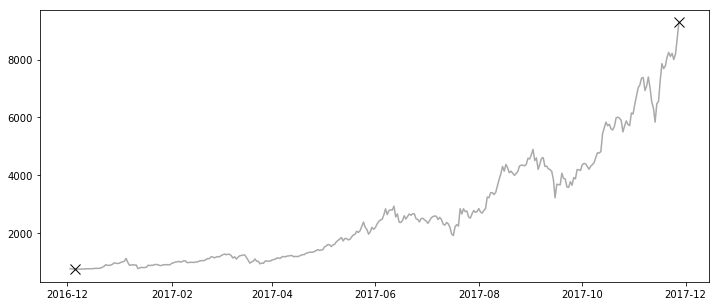

In [6]:
vbt.graphics.plot_line(rate_sr)

# indicators

Calculate EMA indicators.

In [7]:
fast_ma_sr = vbt.indicators.EMA(rate_sr, 20)
slow_ma_sr = vbt.indicators.EMA(rate_sr, 30)

# signals

Generate signals based on conditions.

    1. Go long whenever fast EMA is over slow EMA, while go short when opposite occurs.

In [8]:
ma_entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
ma_exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [9]:
ma_entries = vbt.bitvector.first(ma_entries)
ma_exits = vbt.bitvector.first(ma_exits)

    2. Go short whenever price drops by 10%.

In [10]:
trailstop_exits = vbt.signals.trailstop_exits(rate_sr, ma_entries, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and pick every first exit out of sequence.

In [11]:
ma_exits = vbt.bitvector.OR(ma_exits, trailstop_exits)
ma_exits = vbt.bitvector.first(ma_exits)

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations.

# positions

Generete positions out of both vectors (merge and reduce).

In [12]:
pos_sr = vbt.positions.from_signals(rate_sr, ma_entries, ma_exits)
pos_sr.head()

date
2016-12-17    1
2017-01-06   -1
2017-04-07    1
2017-05-27   -1
2017-07-23    1
dtype: int64

Position series is a binary series, where 1 = going long and -1 = going short. There is no two long/short positions in a row, since we want a clean way to evaluate a strategy (only the logic of a strategy must have an impact on the equity, not the investment size or its distribution)

Visualize entries and exits.

   count       mean          std         min        25%         50%  \
0    4.0  754.16367  1081.787385 -320.649353  82.197662  578.931816   

           75%        max  
0  1250.897824  2179.4404  


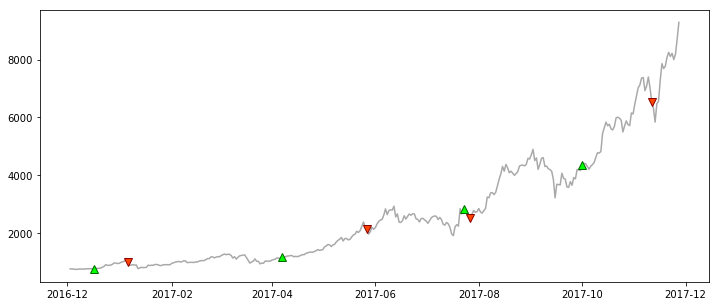

In [13]:
vbt.positions.plot(rate_sr, pos_sr)

# equity

Generate equity from positions, based on fees and slippage.

In [14]:
equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
equity_sr.head()

date
2016-12-03   NaN
2016-12-04   NaN
2016-12-05   NaN
2016-12-06   NaN
2016-12-07   NaN
dtype: float64

Equity is NaN before the first entry or if no positions were taken.

Visualize base and quote equities.

base
   count         mean          std         min          25%         50%  \
0  346.0 -1610.211377  1788.296945 -7716.89545 -2982.957051 -888.812016   

          75%         max  
0 -228.276504  119.438295  


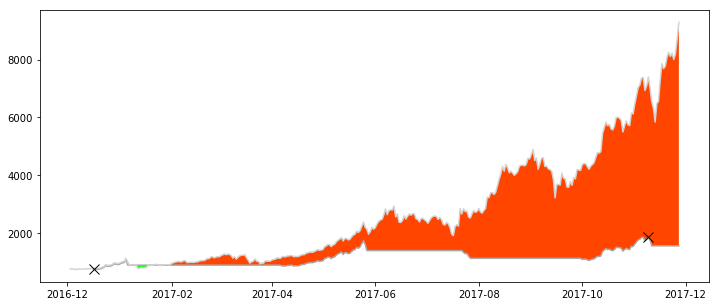

quote
   count      mean       std       min      25%       50%      75%       max
0  346.0 -0.408648  0.272096 -0.831174 -0.72375 -0.387782 -0.20208  0.152763


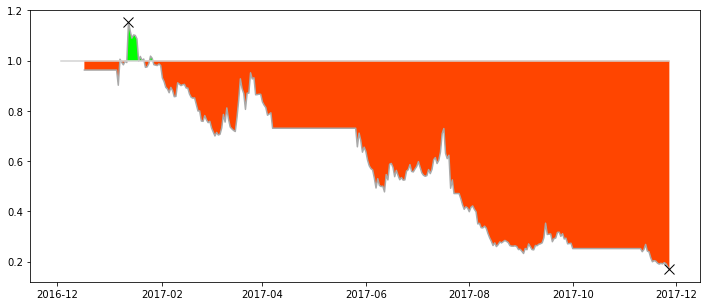

In [15]:
vbt.equity.plot(rate_sr, equity_sr)

# returns

Generate returns.

In [16]:
returns_sr = vbt.returns.from_equity(equity_sr)
returns_sr.head()

date
2016-12-03    0.0
2016-12-04    0.0
2016-12-05    0.0
2016-12-06    0.0
2016-12-07    0.0
dtype: float64

Draw returns.

   count      mean      std       min  25%  50%       75%       max
0   12.0  0.055104  0.15677 -0.188601  0.0  0.0  0.051269  0.354353


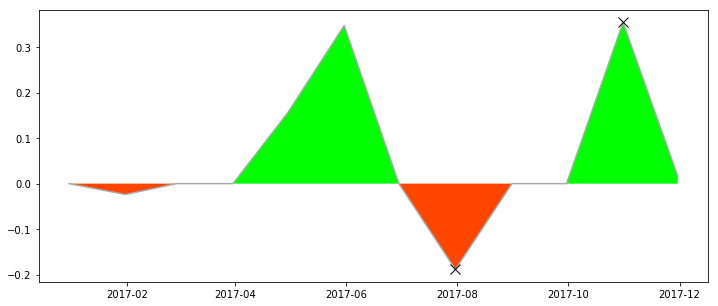

In [39]:
vbt.returns.plot(vbt.returns.resample(returns_sr, 'M'))

# performance

Print summary of multiple KPIs applied on returns.

In [21]:
vbt.performance.summary(returns_sr)

distribution         count         360.000000
                     mean            0.002330
                     std             0.023948
                     min            -0.174607
                     25%             0.000000
                     50%             0.000000
                     75%             0.000000
                     max             0.128133
performance          profit          1.080915
                     avggain         0.029386
                     avgloss         0.033202
                     winrate         0.644068
                     expectancy      0.009160
                     maxdd           0.392300
risk/return profile  sharpe          0.097301
                     sortino         0.062429
dtype: float64

# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 3-4 levels:**

| Level | Motivation | Module | Structure |
|-|-|-|-|
| 1 | Calculate position/equity/returns maps | `srmap` | `{param: pd.Series}` |
| 2 | Calculate KPIs | `nummap` | `pd.Series` |
| 3 (optional) | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Build heatmap to examine hidden patterns | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies.

## L1
## srmap

In [22]:
import vectorbt.optimizer.gridsearch as grids

Calculate returns for a set of MA window combinations.

    1. Precalculate all MAs.

In [23]:
# Init
ma_func = lambda window: vbt.indicators.SMA(rate_sr, window)
min_ma, max_ma, step = 1, 100, 1
fees = 0.0025

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
ma_cache = dict(grids.srmap.from_func(ma_func, param_range))

cores: 4
processes: 1
starmap: False
calcs: 100 (~0.09s) ..
done. 0.03s


    2. For each MA combination, generate position series.

In [24]:
# Params
ma_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)

# Func
def ma_positions_func(fast_ma, slow_ma):
    # Cache
    fast_ma_sr = ma_cache[fast_ma]
    slow_ma_sr = ma_cache[slow_ma]
    # Signals
    entries = vbt.signals.DMAC_entries(fast_ma_sr, slow_ma_sr)
    entries = vbt.bitvector.first(entries)
    exits = vbt.signals.DMAC_exits(fast_ma_sr, slow_ma_sr)
    exits = vbt.bitvector.first(exits)
    # Positions
    pos_sr = vbt.positions.from_signals(rate_sr, entries, exits)
    return pos_sr

In [25]:
ma_positions_srmap = grids.srmap.from_func(ma_positions_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~6.40s) ..
done. 2.14s


    3. For each position series, generate returns series.

We need to separate position and returns calculation, since we need number of positions of each MA combination for a random map.

In [26]:
def ma_returns_func(fast_ma, slow_ma):
    # Equity
    pos_sr = ma_positions_srmap[(fast_ma, slow_ma)]
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [27]:
ma_returns_srmap = grids.srmap.from_func(ma_returns_func, ma_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~18.03s) ..
done. 6.11s


For each MA window combination generate random positions of same length and resulting returns. 

In [28]:
# Params
random_space = [(fma, sma, len(np.flatnonzero(ma_positions_srmap[(fma, sma)].values))) for fma, sma in ma_space]

# Func
def random_returns_func(slow_ma, fast_ma, n):
    # Positions
    pos_sr = vbt.positions.random(rate_sr, n)
    # Equity
    equity_sr = vbt.equity.from_positions(rate_sr, pos_sr, fees, slippage)
    # Returns
    returns_sr = vbt.returns.from_equity(equity_sr)
    return returns_sr

In [29]:
random_returns_srmap = grids.srmap.from_func(random_returns_func, random_space)

cores: 4
processes: 1
starmap: True
calcs: 5050 (~19.66s) ..
done. 7.60s


## L2
## nummap

Apply KPI on each returns series.

In [30]:
ma_profit_nummap = grids.nummap.from_srmap(ma_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~6.33s) ..
done. 2.09s
min (1, 2): -0.861111779497
max (71, 75): 9.24235482658


In [31]:
ma_sharpe_nummap = grids.nummap.from_srmap(ma_returns_srmap, vbt.performance.sharpe)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~1.44s) ..
done. 0.40s
min (1, 2): -0.117145867048
max (9, 21): 0.189896139308


In [32]:
random_profit_nummap = grids.nummap.from_srmap(random_returns_srmap, vbt.performance.profit)

cores: 4
processes: 1
starmap: False
calcs: 5050 (~8.38s) ..
done. 2.18s
min (1, 2, 178): -0.922487009445
max (23, 34, 10): 9.9265900699


Compare quantile distributions of EMA and random strategy.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  4.998990  1.932821 -0.861112  3.411675  5.012204  6.689282   
benchmark  5050.0  1.668073  1.580335 -0.922487  0.499969  1.235097  2.383384   

                max  
nummap     9.242355  
benchmark  9.926590  


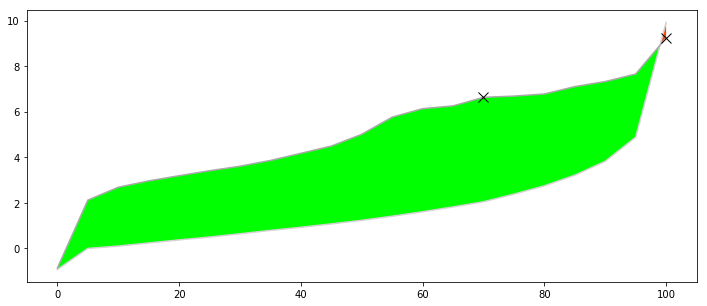

In [33]:
grids.nummap.compare_quantiles(ma_profit_nummap, random_profit_nummap)

Compare their KPI distributions.

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  4.998990  1.932821 -0.861112  3.411675  5.012204  6.689282   
benchmark  5050.0  1.668073  1.580335 -0.922487  0.499969  1.235097  2.383384   

                max  
nummap     9.242355  
benchmark  9.926590  


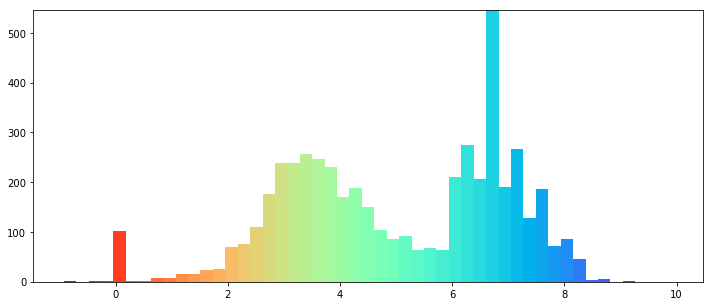

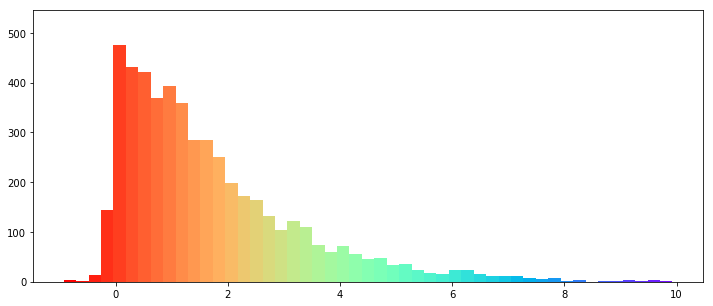

In [34]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
grids.nummap.compare_hists(ma_profit_nummap, random_profit_nummap, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100.

In [35]:
ma_scoremap = grids.scoremap.from_nummaps([ma_profit_nummap, ma_sharpe_nummap], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 2): 1.0
max (71, 75): 98.4897365643


## L4
## matrix

Reshape 2d-parameter grid into a matrix.

In [36]:
ma_matrix = grids.matrix.from_nummap(ma_profit_nummap, symmetric=True).fillna(0)

done. 1.40s


Display as a heatmap.

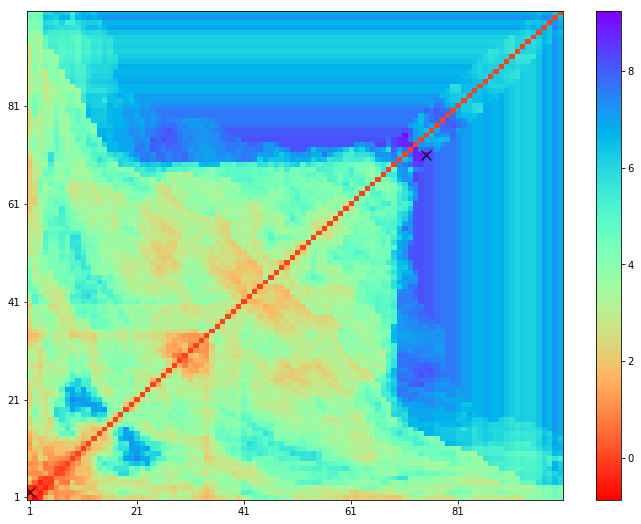

In [37]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)